In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

In [2]:
%matplotlib inline

In [3]:
# confidence limits for 1, 2, and 3 standard deviations in 1 dimension
nstd1 = 2. * (norm.cdf(1) - 0.5)
nstd2 = 2. * (norm.cdf(2) - 0.5)
nstd3 = 2. * (norm.cdf(3) - 0.5)
#print (nstd1, nstd2, nstd3)

# confidence limits in two dimensions
l90 = chi2.ppf(0.90, 2)
# 68.3% = 1 std dev (1 dim)
l68 = chi2.ppf(nstd1, 2)
# 95.4% = 2 std dev (1 dim)
l95 = chi2.ppf(nstd2, 2)
# 99.7% = 3 std dev (1 dim)
l99 = chi2.ppf(nstd3, 2)

# scales with which to scale up r1 and r2
scale1 = np.sqrt(l68)
scale2 = np.sqrt(l95)
scale3 = np.sqrt(l99)
#print (scale1, scale2, scale3)

print (l68, l90, l95, l99)

2.295748928898636 4.605170185988092 6.180074306244173 11.829158081900795


In [4]:
# confusion matrix to use here
x = np.array([10, 1, 180, 1809])

In [5]:
# three different priors for Dirichlet: jeffrey's, uniform, Legendre
alphaJ = np.array([0.5, 0.5, 0.5, 0.5])
alphaU = np.array([1, 1, 1, 1])
alphaL = np.array([2, 2, 2, 2])

In [6]:
# sample the posterior Dirichlet-MN distribution, for the three priors 
pJ = np.random.dirichlet(alpha=x+alphaJ, size=100_000)
pU = np.random.dirichlet(alpha=x+alphaU, size=100_000)
pL = np.random.dirichlet(alpha=x+alphaL, size=100_000)

In [7]:
# evaluate precision and recall for three priors
PJ = pJ[:, 0] / (pJ[:, 0] + pJ[:, 1])
RJ = pJ[:, 0] / (pJ[:, 0] + pJ[:, 2])

PU = pU[:, 0] / (pU[:, 0] + pU[:, 1])
RU = pU[:, 0] / (pU[:, 0] + pU[:, 2])

PL = pL[:, 0] / (pL[:, 0] + pL[:, 1])
RL = pL[:, 0] / (pL[:, 0] + pL[:, 2])

In [9]:
# Recall-Precision pdf for Dirichlet-MN distribution (up to normalization constant)
# Function returns -2 log pdf(R, P), as a function of alpha vector. 

def neglogRPpdf(R, P, alpha):
    invgamma = 1/(1/R + 1/P - 1)
    ratioR = (1 - R) / R
    ratioP = (1 - P) / P
    logfact = -2 * np.log(R) - 2 * np.log(P)
    logpowP = (alpha[1] - 1) * np.log(ratioP)
    logpowR = (alpha[2] - 1) * np.log(ratioR)
    logpowIG = (alpha[0] + alpha[1] + alpha[2]) * np.log(invgamma) 
    logpdf = logfact + logpowP + logpowR + logpowIG
    return -2. * logpdf

In [10]:
# pdf values for Jeffrey's prior
nlogpdfJ = neglogRPpdf(RJ, PJ, x+alphaJ)
spdfJ = sorted(nlogpdfJ)

nlogpdfU = neglogRPpdf(RU, PU, x+alphaU)
spdfU = sorted(nlogpdfU)

nlogpdfL = neglogRPpdf(RL, PL, x+alphaL)
spdfL = sorted(nlogpdfL)

In [11]:
minpdfJ = np.min(spdfJ)
diffJ = np.max(spdfJ) - minpdfJ
diffJ 

25.380320721312955

In [12]:
minpdfU = np.min(spdfU)
diffU = np.max(spdfU) - minpdfU
diffU 

20.8802004992574

In [13]:
minpdfL = np.min(spdfL)
diffL = np.max(spdfL) - minpdfL
diffL 

22.91353614135039

In [14]:
# the function fJ converts the pdf value into the chi2 score for 2 d.o.f.
# this is used in the plotting of the contour.
nbins = len(pJ)
qs = (np.linspace(0, nbins - 1, nbins) + 0.5) / nbins
Z2 = chi2.ppf(qs, 2)

fJ = scipy.interpolate.interp1d(spdfJ, Z2, bounds_error=False, fill_value=(0, 100))
fU = scipy.interpolate.interp1d(spdfU, Z2, bounds_error=False, fill_value=(0, 100))
fL = scipy.interpolate.interp1d(spdfL, Z2, bounds_error=False, fill_value=(0, 100))

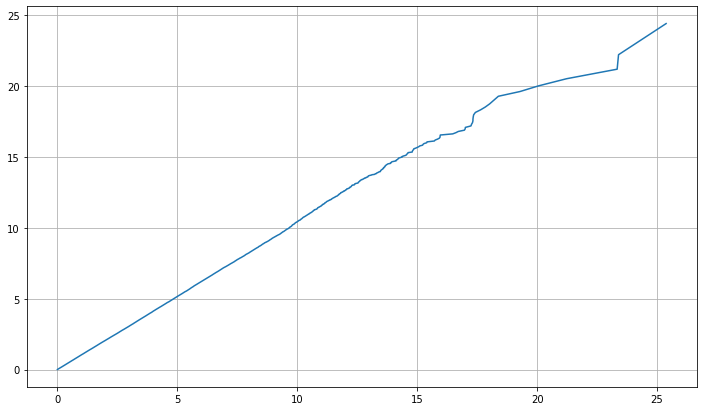

In [15]:
# note: near but not an exact linear mapping between pdf value and chi^2 with 2 dof.
# so important to apply the mapping from pdf to Z score.
plt.figure(figsize=(12,7))
plt.plot(spdfJ - minpdfJ, Z2)
plt.grid()

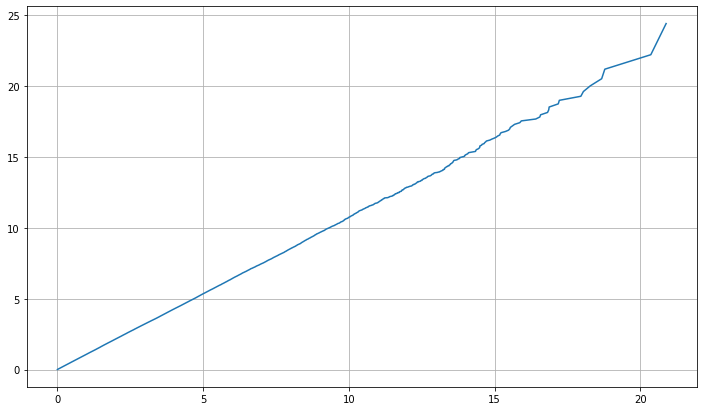

In [16]:
# note: near but not an exact linear mapping between pdf value and chi^2 with 2 dof.
# so important to apply the mapping from pdf to Z score.
plt.figure(figsize=(12,7))
plt.plot(spdfU - minpdfU, Z2)
plt.grid()

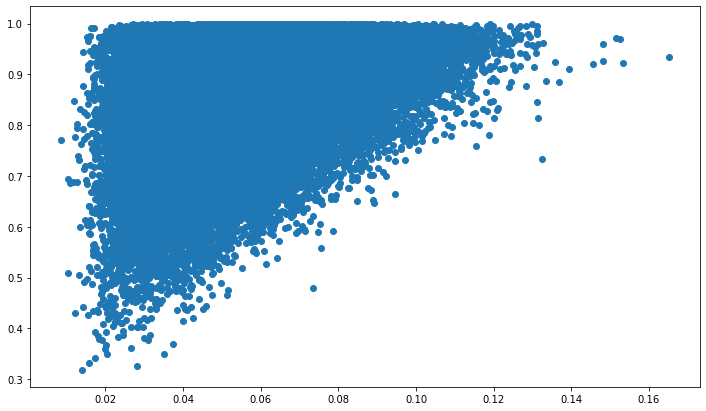

In [17]:
# just a plot to see how recall vs precision looks like for this confusion matrix
plt.figure(figsize=(12, 7))
plt.scatter(x=RJ, y=PJ)

In [18]:
# make fixed PR grid to scan
nbins = 1000
rx = np.linspace(0.001, 1 - 0.001, nbins)
py = np.linspace(0.001, 1 - 0.001, nbins)
RX, PY = np.meshgrid(rx, py)


In [19]:
# Calculation posterior pdf values, and convert these to Z-scores.
z2pdfJ = fJ(neglogRPpdf(RX, PY, x+alphaJ))

z2pdfU = fU(neglogRPpdf(RX, PY, x+alphaU))

z2pdfL = fL(neglogRPpdf(RX, PY, x+alphaL))

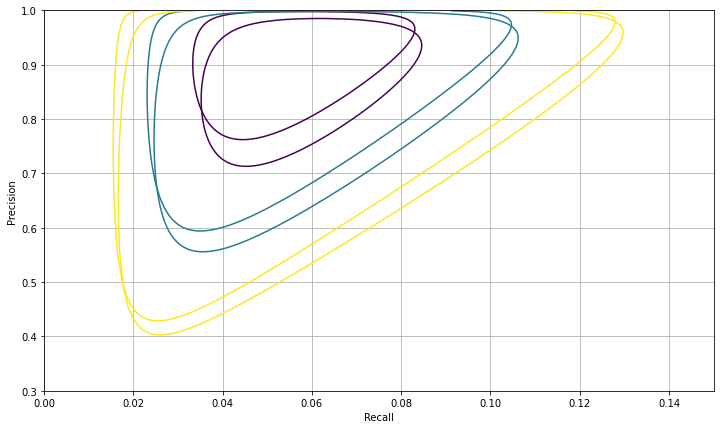

In [20]:
# plot contours based on Z-scores
fig, ax = plt.subplots(figsize=(12, 7))
CS = ax.contour(RX, PY, z2pdfJ, levels=[l68, l95, l99])
CS = ax.contour(RX, PY, z2pdfU, levels=[l68, l95, l99])
#CS = ax.contour(RX, PY, z2pdfL, levels=[l68, l95, l99])
plt.ylim((0.3,1))
plt.xlim((0,0.15))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()